# **Part 1: Importing Libraries and Reading Data**

In [132]:
# Import necessary libraries
# !pip install pyarabic
# !pip install transformers

import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
import tensorflow as tf
from keras import Input, Model
from keras.models import load_model
from keras.layers import *
from keras import utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from transformers import AutoTokenizer, TFAutoModel, AutoConfig
import xml.etree.ElementTree as ET
from transformers import TFBertModel


# Function to read XML data and convert it to a DataFrame
def read_xlm_as_dataframe(file):
    tree = ET.parse(file)
    reviews = tree.getroot()
    sent_ids, sentences, targets, polarities = [], [], [], []
    
    for i, sentence in enumerate(reviews.iter('sentence')):
        ids, tar, p, texts = [], [], [], []
        for text in sentence.iter('text'):
            t = text.text
        for op in sentence.iter('Opinion'):
            tr = op.attrib.get('target')
            if tr != "NULL":
                tar.append(tr)
                p.append(op.attrib.get('polarity'))
        if len(tar) > 1:
            for i in range(len(tar)):
                texts.append(t)
                ids.append(sentence.attrib.get('id'))
        if len(tar) == 1:
            texts.append(t)
            ids.append(sentence.attrib.get('id'))

        sent_ids.extend(ids)
        sentences.extend(texts)
        targets.extend(tar)
        polarities.extend(p)
        
    df = pd.DataFrame(list(zip(sent_ids, sentences, targets, polarities)), columns=['id', 'text', 'term', 'polarity'])
    return df

# **Part 2: Loading and Preprocessing Data**

In [133]:
reviews_train = read_xlm_as_dataframe("/kaggle/input/private-dataset/AR_Hotels_Train_SB1 (2).xml")
reviews_test = read_xlm_as_dataframe("/kaggle/input/private-dataset/AR_HOTE_SB1_TEST (3).xml")

import pyarabic.araby as araby
import re


def text_preprocessing(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub("\d+", " ", text)
    text = normalizeArabic(text)
    text = re.sub('[A-Za-z]+', ' ', text)
    text = re.sub(r'\\u[A-Za-z0-9\\]+', ' ', text)
    return text


def normalizeArabic(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text)  # Remove longation
    return araby.strip_tashkeel(text)


reviews_train['text'] = reviews_train['text'].apply(lambda x: text_preprocessing(x))
reviews_train['term'] = reviews_train['term'].apply(lambda x: text_preprocessing(x))
reviews_test['text'] = reviews_test['text'].apply(lambda x: text_preprocessing(x))
reviews_test['term'] = reviews_test['term'].apply(lambda x: text_preprocessing(x))

class_map = {"negative": 0, "neutral": 1, "positive": 2}
reviews_train['label'] = reviews_train['polarity'].map(class_map)
reviews_test['label'] = reviews_test['polarity'].map(class_map)


def get_one_hot_labels():
    enc = OneHotEncoder(handle_unknown='ignore')
    train_y = enc.fit_transform(reviews_train['label'].values.reshape(-1, 1)).todense()
    test_y = enc.fit_transform(reviews_test['label'].values.reshape(-1, 1)).todense()
    return train_y, test_y, enc


reviews_train['polarity'].value_counts()

reviews_train['label'].value_counts()

label
2    5819
0    3141
1     660
Name: count, dtype: int64

# **Part 3: Tokenization and Model Setup**

In [134]:
train_y, test_y, enc = get_one_hot_labels()

tokenizer = AutoTokenizer.from_pretrained('aubmindlab/bert-base-arabertv02')

# Tokenize data
def tokenize(sentences, aspects, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for i in range(len(sentences)):
        inputs = tokenizer.encode_plus(sentences[i], aspects[i],
                                       add_special_tokens=True,
                                       max_length=100,
                                       pad_to_max_length=True,
                                       return_attention_mask=True,
                                       return_token_type_ids=True,
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])

        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')


X_train = tokenize(reviews_train['text'], reviews_train['term'], tokenizer)
X_test = tokenize(reviews_test['text'], reviews_test['term'], tokenizer)


# Get the Arabert model and its configuration
config = AutoConfig.from_pretrained('aubmindlab/bert-base-arabertv02', output_hidden_states=True, output_attentions=True)
arabertembedding = TFAutoModel.from_pretrained('aubmindlab/bert-base-arabertv02', config=config)


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'bert.embeddings.position_ids', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on 

# **Part 4: Model Architecture and Training**

In [135]:
# Get the number of layers in the Arabert model
num_layers = arabertembedding.config.num_hidden_layers


# Print the number of layers
print(f"Number of layers in Arabert model: {num_layers}")


#Attention
class Attention(tf.keras.layers.Layer):
    def __init__(self, units, layer_index, name="attention"):
        super(Attention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)
        self.layer_index = layer_index

    def call(self, features):
        attention_layer_name = f'attention_{self.layer_index}'  # Update the layer index
        hidden = features[:, -1, :]
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

    
# Input layers
input_ids_in = Input(shape=(100,), dtype='int32', name="input_ids_in")
input_masks_in = Input(shape=(100,), dtype='int32', name="input_masks_in")


# Loop through Arabert layers
for layer_index in range(num_layers):
    # Extract the hidden states from the specific layer
    layer_output = arabertembedding(input_ids=input_ids_in, attention_mask=input_masks_in)[2][layer_index]

    # Apply attention to the Arabert layer output
    context_vector, attention_weights = Attention(256, layer_index,name=f'attention_{layer_index}')(layer_output)



    # Apply additional layers (e.g., GRU, Dropout)
    gru_output = Bidirectional(GRU(256, return_sequences=True))(layer_output)
    X2 = tf.keras.layers.Dropout(0.1)(layer_output)
    X3 = tf.keras.layers.Dropout(0.1)(layer_output)
    

#   Concatenate the outputs of the layers together
    if layer_index == 0:
        
        # If it's the first layer, apply global average pooling along the last axis for tensors with a time dimension
        gru_output = GlobalAveragePooling1D()(gru_output)
        
#       context_vector = GlobalAveragePooling1D()(context_vector)
        context_vector = context_vector
        X2 = GlobalAveragePooling1D()(X2)
        X3 = GlobalAveragePooling1D()(X3)
        

        # Now, concatenate along the last axis
        all_concatenated_embeddings = tf.concat([gru_output, context_vector, X2, X3], axis=-1)
        
    else:
        # If it's not the first layer, make sure the last dimensions match before concatenation
        layer_output_shape = layer_output.shape[-1]
        gru_output = tf.keras.layers.Dense(layer_output_shape)(GlobalAveragePooling1D()(gru_output))


#       context_vector = tf.keras.layers.Dense(layer_output_shape)(GlobalAveragePooling1D()(context_vector))
        context_vector = tf.keras.layers.Dense(layer_output_shape)(context_vector)
        X2 = tf.keras.layers.Dense(layer_output_shape)(GlobalAveragePooling1D()(X2))
        X3 = tf.keras.layers.Dense(layer_output_shape)(GlobalAveragePooling1D()(X3))

#       Now, concatenate along the last axis
        all_concatenated_embeddings = tf.concat([gru_output, context_vector, X2, X3], axis=-1)



# Dense layer (x4)
X4 = tf.keras.layers.Dense(128, activation='relu')(all_concatenated_embeddings)
X5 = tf.keras.layers.Dropout(0.2)(all_concatenated_embeddings)


# Output layer (x_last)
X_last = tf.keras.layers.Dense(len(enc.categories_[0]), activation='softmax', name="output")(all_concatenated_embeddings)



# Create the final model
model = Model(inputs=[input_ids_in, input_masks_in], outputs=X_last)
model.summary()


# Model callbacks
checkpoint = ModelCheckpoint("SemEval2016_arabic/aspect_model_hotel.h5",
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)




#Compile Model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=2e-5), metrics=['accuracy'])



# Model training
# # Example: Early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(X_train, train_y, validation_split=0.05, epochs=15, batch_size=8, callbacks=[checkpoint], verbose=1)



Number of layers in Arabert model: 12
Model: "model_297"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids_in (InputLayer)   [(None, 100)]                0         []                            
                                                                                                  
 input_masks_in (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_61 (TFBertMo  TFBaseModelOutputWithPooli   1351933   ['input_ids_in[0][0]',        
 del)                        ngAndCrossAttentions(last_   44         'input_masks_in[0][0]']      
                             hidden_state=(None, 100

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1143/1143 [==============================] - 231s 159ms/step - loss: 0.3423 - accuracy: 0.8766 - val_loss: 0.3026 - val_accuracy: 0.9085
Epoch 2/15
1143/1143 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9277
Epoch 2: val_accuracy improved from 0.90852 to 0.91268, saving model to SemEval2016_arabic/aspect_model_hotel.h5
1143/1143 [==============================] - 161s 141ms/step - loss: 0.2075 - accuracy: 0.9277 - val_loss: 0.2735 - val_accuracy: 0.9127
Epoch 3/15
1143/1143 [==============================] - ETA: 0s - loss: 0.1495 - accuracy: 0.9481
Epoch 3: val_accuracy did not improve from 0.91268
1143/1143 [==============================] - 156s 136ms/step - loss: 0.1495 - accuracy: 0.9481 - val_loss: 0.2947 - val_accuracy: 0.8919
Epoch 4/15
1143/1143 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.9653
Epoch 4: val_accuracy did not improve from 0.91268
1143/1143 [==============================] - 153s 134ms/step - loss: 0.0998 - ac

# **Part 5: Model Evaluation and Visualization**

/tmp/ipykernel_43/354422481.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


1/1 [==============================] - 4s 4s/step


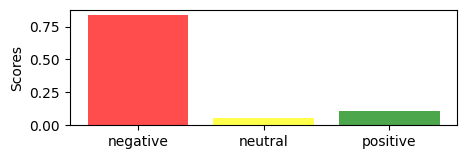

1/1 [==============================] - 4s 4s/step


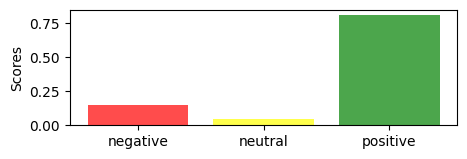

1/1 [==============================] - 4s 4s/step


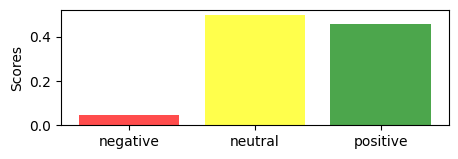

1/1 [==============================] - 4s 4s/step


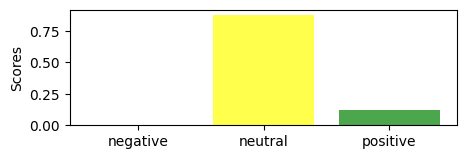

1/1 [==============================] - 4s 4s/step


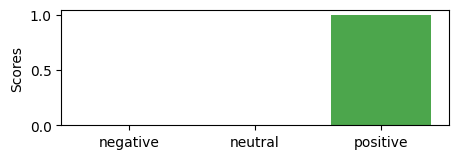

1/1 [==============================] - 4s 4s/step


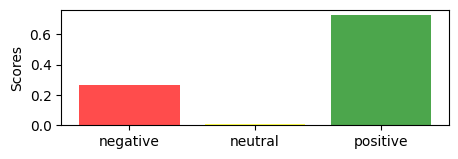

1/1 [==============================] - 4s 4s/step


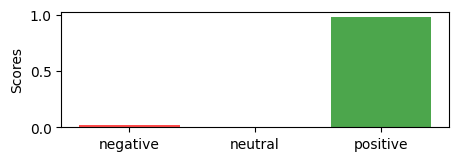

1/1 [==============================] - 4s 4s/step


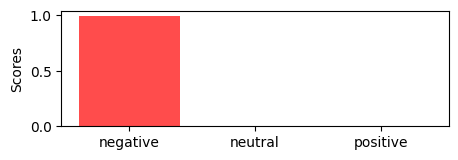

1/1 [==============================] - 4s 4s/step


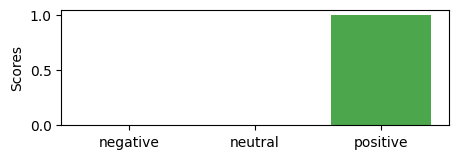

1/1 [==============================] - 4s 4s/step


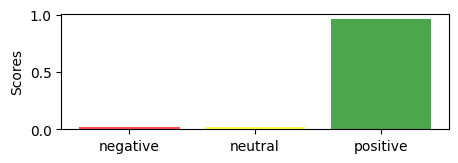

1/1 [==============================] - 4s 4s/step


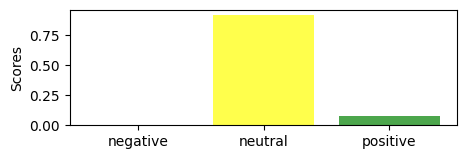

1/1 [==============================] - 4s 4s/step


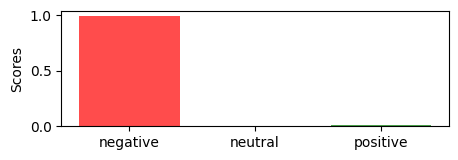

1/1 [==============================] - 4s 4s/step
[[1.5951353e-03 4.5212309e-04 9.9795270e-01]]
2


In [136]:
from IPython.core.display import display, HTML


# Define custom_objects dictionary
custom_objects = {
    "Attention": Attention,
    "TFAutoModel": TFAutoModel,
    "TFBertModel": TFBertModel,
    "arabertembedding": arabertembedding
}

# Load the best model
best_model = tf.keras.models.load_model('SemEval2016_arabic/aspect_model_hotel.h5', custom_objects=custom_objects)


# Evaluate the best model on the test set
best_model.evaluate(X_test, test_y)


# Function to convert RGB to hex
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def attention2color(attention_score, label):
    r = 255 - int(attention_score * 255)
    color = rgb_to_hex((255, r, r))
    return str(color)

def visualize_attention():
    # Dynamic search for attention layers
    attention_layers = [layer for layer in best_model.layers if isinstance(layer, Attention)]
    
    # Ensure there are attention layers
    if not attention_layers:
        print("No attention layers found.")
        return
    
    for layer_index, attention_layer in enumerate(attention_layers):
        attention_layer_name = attention_layer.name

        model_att = Model(inputs=best_model.input, outputs=[best_model.output, attention_layer.output[-1]])

        idx = np.random.randint(low=0, high=X_test[0].shape[0])  # Get a random test
        tokenized_sample = np.trim_zeros(X_test[0][idx])  # Get the tokenized text
        label_probs, attentions = model_att.predict((X_test[0][idx].reshape(1, -1), X_test[1][idx].reshape(1, -1)))


    
    # Perform the prediction
    po=reviews_test['polarity'][idx]
    aspect=reviews_test['term'][idx]
    # print(idx)
    # Get decoded text and labels
    decoded_text = tokenizer.decode(tokenized_sample)
    #print(decoded_text)

    
    # Get classification
    label = np.argmax(label_probs) # Only one
    # print(label)
    #label2id = ['negative', 'neutral', 'positive']

    
    # Get word attentions using attenion vector
    token_attention_dic = {}
    max_score = 0.0
    min_score = 0.0

    attentions_text = attentions[-len(tokenized_sample):]
    attentions_text = (attentions_text - np.min(attentions_text)) / (np.max(attentions_text) - np.min(attentions_text))
    for token, attention_score in zip(decoded_text.split(), attentions_text):
        #print(token, attention_score)
        if token not in ["[SEP]", "[CLS]"]:
          token_attention_dic[token] = attention_score


    # Build HTML String to viualize attentions
    html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
    html_text1 = "<hr><p style='font-size: large'><b>Aspect:  </b>"+aspect
    html_text2 = "<hr><p style='font-size: large'><b>Polarity:  </b>"+po
    for token, attention in token_attention_dic.items():
        html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention, label), token)



    # Display text enriched with attention scores
    display(HTML(html_text))
    display(HTML(html_text1))
    display(HTML(html_text2))
    # PLOT EMOTION SCORES
    _labels = ['negative', 'neutral', 'positive']

    probs = label_probs
    plt.figure(figsize=(5,1.5))
    plt.bar(np.arange(len(_labels)), probs.squeeze(), align='center', alpha=0.7, color=[ 'red', 'yellow', 'green'])
    plt.xticks(np.arange(len(_labels)), _labels)
    plt.ylabel('Scores')
    plt.show()

    
# Apply the visualize_attention function to see the attention visualization
for layer_index in range(num_layers):
#     visualize_attention()
    visualize_attention()

    
def tokenize_one_sen(sentence,aspect, tokenizer):
    input_ids, input_masks, input_segments = [], [], []

    inputs = tokenizer.encode_plus(sentence, aspect,
                                       add_special_tokens=True,
                                       max_length=100,
                                       pad_to_max_length=True,
                                       return_attention_mask=True,
                                       return_token_type_ids=True, truncation=True)
    input_ids.append(inputs['input_ids'])
    input_masks.append(inputs['attention_mask'])
    input_segments.append(inputs['token_type_ids'])
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')


# Tokenize and predict for a single sentence and aspect
text = 'وكذلك اود ان اشير الي حسن الضيافه والاستقبال من طاقم الاستقبال و اخص المستر اسامه خليفه لتفانيه في خدمه العملاء'
aspect = 'حسن الضيافه'

#preprocessing
text = text_preprocessing(text)
aspect = text_preprocessing(aspect)

check_sen = tokenize_one_sen(text, aspect, tokenizer)


output = best_model.predict(check_sen)
print(output)
label = output.argmax()
sentiment = enc.categories_[0][label]
print(sentiment)
